In [68]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [69]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [70]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [71]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [72]:
tf.keras.backend.clear_session()

In [73]:
subject = 'Minas Gerais - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [74]:
data = pd.read_csv('2003_mo_model_input_MG.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Consumo de Cimento (t),Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,2003-1,10943.259600,0.756537,247.134,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175
1,2003-2,11044.202677,0.756708,305.708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617
2,2003-3,11138.440825,0.756879,284.168,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060
3,2003-4,11231.690825,0.757050,286.594,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502
4,2003-5,11322.829101,0.757222,312.455,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


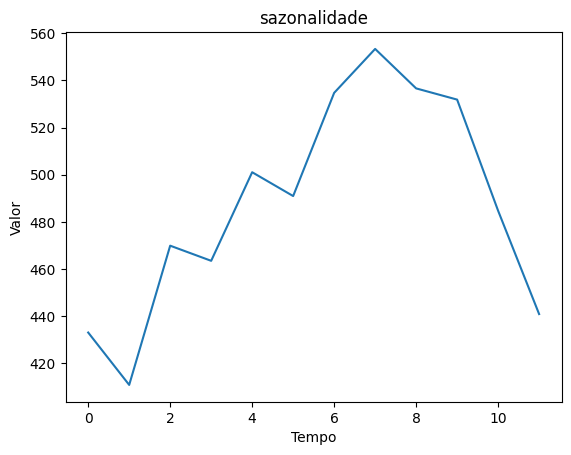

,sazonalidade
sazonalidade,
0,433.074877
1,410.853921
2,469.902617
3,463.483342
4,501.051317
5,490.953269
6,534.709632
7,553.345679
8,536.608438


In [75]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [76]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade,Minas Gerais - Consumo de Cimento (t)
0,2003-1,10943.259600,0.756537,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175,433.074877,247.134
1,2003-2,11044.202677,0.756708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617,410.853921,305.708
2,2003-3,11138.440825,0.756879,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060,469.902617,284.168
3,2003-4,11231.690825,0.757050,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502,463.483342,286.594
4,2003-5,11322.829101,0.757222,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945,501.051317,312.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.051317,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.953269,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.709632,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,553.345679,NaN


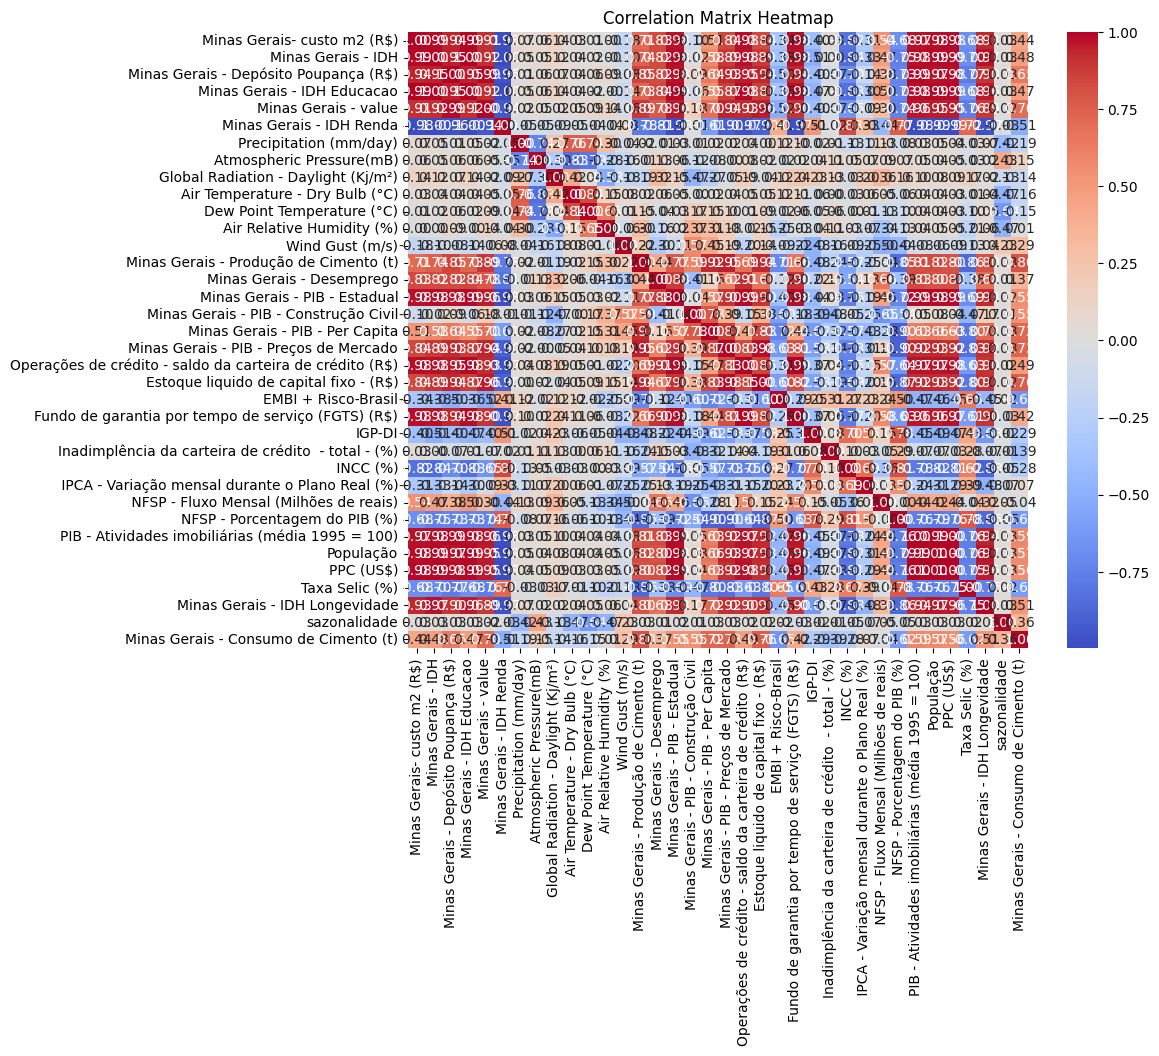

In [77]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [78]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [79]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,-1.604733,-1.917914,-1.653109,-1.774202,-1.524203,1.929432,0.569744,0.405068,0.701907,0.185208,1.501626,2.473320,-4.333238,-2.146709,-0.699400,-1.745399,-1.973963,-3.018821,-2.686146,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-2.448814,-1.244818
1,-1.582777,-1.892160,-1.643313,-1.754356,-1.508666,1.904269,0.548062,0.454590,0.535687,-0.282236,0.739319,1.716824,-4.333238,-2.125900,-0.706157,-1.725016,-1.923436,-2.934320,-2.623049,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-2.401003,-1.751928
2,-1.562278,-1.866406,-1.633517,-1.734511,-1.496577,1.879107,-0.023148,0.577370,0.489784,-0.462795,0.038856,0.667739,-4.333238,-2.105031,-0.712914,-1.704633,-1.872910,-2.849818,-2.559951,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-2.353192,-0.404362
3,-1.541995,-1.840653,-1.623720,-1.714666,-1.496879,1.853945,-0.755514,1.002803,0.187639,-0.910888,-0.700373,-0.044993,-4.152822,-2.100075,-0.719672,-1.684250,-1.822384,-2.765317,-2.496853,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-2.305382,-0.550858
4,-1.522171,-1.814899,-1.613924,-1.694821,-1.498597,1.828782,-1.085703,1.172006,0.220940,-1.479870,-1.463202,-0.740685,-3.720662,-2.080078,-0.726429,-1.663867,-1.771858,-2.680816,-2.433756,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-2.257571,0.306491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.758872,1.315321,1.211211,1.407871,0.874645,-1.328539,0.970821,0.258320,-0.805508,-0.875907,-0.534471,0.236522,-0.587203,0.774558,0.789659,1.149269,-0.772657,0.183801,0.694771,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.128237,1.499915
188,1.783145,1.308842,1.226046,1.408937,0.890157,-1.329205,1.225461,-0.397241,-0.305413,-0.235972,0.004219,0.306158,-0.620933,0.806353,0.784605,1.140354,-0.757425,0.173158,0.684584,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.112912,1.117950
189,1.809687,1.302363,1.240881,1.410003,0.906034,-1.329871,1.709580,-0.508089,0.370290,0.502599,0.515241,0.206625,-0.975326,0.844284,0.779552,1.131439,-0.742194,0.162516,0.674397,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.097586,1.009433
190,1.838675,1.295885,1.255716,1.411069,0.919415,-1.330537,1.790915,-0.713258,0.845625,1.058426,0.868770,0.089936,-1.671516,0.884141,0.774

In [80]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      249.680
1      219.561
2      304.641
3      262.564
4      299.209
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Minas Gerais - Consumo de Cimento (t), Length: 249, dtype: float64

In [81]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,-1.604733,-1.917914,-1.653109,-1.774202,-1.524203,1.929432,0.569744,0.405068,0.701907,0.185208,1.501626,2.473320,-4.333238,-2.146709,-0.699400,-1.745399,-1.973963,-3.018821,-2.686146,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-2.448814,-1.244818
1,-1.582777,-1.892160,-1.643313,-1.754356,-1.508666,1.904269,0.548062,0.454590,0.535687,-0.282236,0.739319,1.716824,-4.333238,-2.125900,-0.706157,-1.725016,-1.923436,-2.934320,-2.623049,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-2.401003,-1.751928
2,-1.562278,-1.866406,-1.633517,-1.734511,-1.496577,1.879107,-0.023148,0.577370,0.489784,-0.462795,0.038856,0.667739,-4.333238,-2.105031,-0.712914,-1.704633,-1.872910,-2.849818,-2.559951,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-2.353192,-0.404362
3,-1.541995,-1.840653,-1.623720,-1.714666,-1.496879,1.853945,-0.755514,1.002803,0.187639,-0.910888,-0.700373,-0.044993,-4.152822,-2.100075,-0.719672,-1.684250,-1.822384,-2.765317,-2.496853,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-2.305382,-0.550858
4,-1.522171,-1.814899,-1.613924,-1.694821,-1.498597,1.828782,-1.085703,1.172006,0.220940,-1.479870,-1.463202,-0.740685,-3.720662,-2.080078,-0.726429,-1.663867,-1.771858,-2.680816,-2.433756,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-2.257571,0.306491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.119063,1.399834,0.698008,1.355364,0.832198,-1.319310,1.592778,-0.157724,1.208478,1.533417,1.082584,-0.239523,-0.864708,0.050588,1.519517,1.163052,-0.960847,-0.093961,0.627995,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,1.446469,-1.751928
158,1.140810,1.402752,0.714679,1.360266,0.824048,-1.324135,0.921228,0.418547,0.303519,0.611670,0.561310,0.072348,-0.835480,0.042723,1.476375,1.168317,-0.968515,-0.074705,0.638908,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,1.439344,-0.404362
159,1.159038,1.405671,0.731350,1.365169,0.815727,-1.328960,0.021265,0.873522,-0.046361,-0.155016,-0.230685,-0.276998,-0.847441,0.029152,1.433232,1.173583,-0.976183,-0.055448,0.649820,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,1.432218,-0.550858
160,1.177318,1.408589,0.748021,1.370072,0.810089,-1.333786,-0.134082,1.267294,-0.333524,-0.915473,-0.927276,-0.460208,-0.705967,-0.007439,1

In [82]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      249.680
1      219.561
2      304.641
3      262.564
4      299.209
        ...   
157    338.767
158    419.962
159    387.800
160    391.122
161    409.739
Name: Minas Gerais - Consumo de Cimento (t), Length: 162, dtype: float64

In [83]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [84]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [85]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
126,0.467117,0.544198,1.162125,0.555372,1.135116,-0.656829,-1.182549,1.321588,-1.359761,-1.373459,-0.725366,0.710973,0.211800,0.964210,1.008346,0.811298,0.287865,0.502913,0.863809,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.344129,1.074617
127,0.485881,0.559144,1.179222,0.573759,1.150078,-0.649246,-0.859371,0.729188,-0.670828,-1.055265,-0.689920,0.267703,0.322170,0.924638,1.051039,0.826912,0.237130,0.464014,0.848131,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,0.340546,1.499915
128,0.505161,0.574090,1.196319,0.592145,1.162632,-0.641662,-0.827146,-0.202131,-0.538745,-0.592964,-0.218310,0.445679,0.289697,0.882104,1.093731,0.842525,0.186395,0.425115,0.832454,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.336963,1.117950
129,0.524248,0.589036,1.213416,0.610532,1.166985,-0.634079,0.041639,-0.703217,0.633040,0.045689,-0.008282,-0.092241,0.093304,0.846537,1.136424,0.858138,0.135660,0.386216,0.816777,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.333380,1.009433
130,0.543807,0.603982,1.230513,0.628918,1.145581,-0.626496,-0.157354,-1.071388,1.646744,0.753868,0.307139,-0.528054,-0.104626,0.796933,1.179116,0.873751,0.084924,0.347317,0.801100,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.329797,-0.066277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.758872,1.315321,1.211211,1.407871,0.874645,-1.328539,0.970821,0.258320,-0.805508,-0.875907,-0.534471,0.236522,-0.587203,0.774558,0.789659,1.149269,-0.772657,0.183801,0.694771,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.128237,1.499915
188,1.783145,1.308842,1.226046,1.408937,0.890157,-1.329205,1.225461,-0.397241,-0.305413,-0.235972,0.004219,0.306158,-0.620933,0.806353,0.784605,1.140354,-0.757425,0.173158,0.684584,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.112912,1.117950
189,1.809687,1.302363,1.240881,1.410003,0.906034,-1.329871,1.709580,-0.508089,0.370290,0.502599,0.515241,0.206625,-0.975326,0.844284,0.779552,1.131439,-0.742194,0.162516,0.674397,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.097586,1.009433
190,1.838675,1.295885,1.255716,1.411069,0.919415,-1.330537,1.790915,-0.713258,0.845625,1.058426,0.868770,0.089936,-1.671516,0.884141,0.774498,1.122523,-0.726963,0.151874,0.664209,1.37097

In [86]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [87]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [88]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=20)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
#                         validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [89]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_val_loss = min(history.history['val_loss'][20:])
        current_loss = history.history['loss'][history.history['val_loss'].index(current_val_loss)]
        decision_value = (current_val_loss*current_val_loss)*current_loss 
        print(f"val_loss: {current_val_loss}; loss={current_loss} => decision_value={decision_value}")

        if decision_value < best_loss:
            best_loss = decision_value
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [90]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3494167940, 1232611780, 2536463690, 3632770735, 524980070, 491394871, 2206255719, 517635944, 232370605, 1498737239]


Step: 0 ___________________________________________
val_loss: 3306.2060546875; loss=3257.634765625 => decision_value=35609200658.58182
winner_seed: 3494167940


Step: 1 ___________________________________________
val_loss: 9244.8642578125; loss=8436.396484375 => decision_value=721037844300.743


Step: 2 ___________________________________________
val_loss: 7824.20556640625; loss=7966.26025390625 => decision_value=487680055683.51294


Step: 3 ___________________________________________
val_loss: 1182.989501953125; loss=3579.815185546875 => decision_value=5009823057.794346
winner_seed: 3632770735


Step: 4 ___________________________________________
val_loss: 9347.02734375; loss=8438.71875 => decision_value=737264867324.5367


Step: 5 ___________________________________________
val_loss: 2905.750244140625; loss=3371.432373046875 => decision_value=28466299778.414978


Ste

In [91]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 180ms/step - loss: 235390.2969 - val_loss: 17971.5664
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 12032.8877 - val_loss: 9444.7568
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 8557.7363 - val_loss: 9637.9668
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 8443.6777 - val_loss: 9588.0898
Epoch 5/10000
4/4 [==============================] - 0s 13ms/step - loss: 8377.0576 - val_loss: 9350.9375
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 8611.9160 - val_loss: 9852.6494
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 8968.2490 - val_loss: 9440.4004
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 8369.8945 - val_loss: 9347.5752
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 8347.0381 - val_loss: 9547.4023
Epoch 10/10000
4/4 [=====================

4/4 [==============================] - 0s 12ms/step - loss: 8465.0420 - val_loss: 9751.8320
Epoch 78/10000
4/4 [==============================] - 0s 12ms/step - loss: 8460.2725 - val_loss: 9362.9590
Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 8491.5176 - val_loss: 10000.7373
Epoch 80/10000
4/4 [==============================] - 0s 11ms/step - loss: 8832.8770 - val_loss: 9476.0088
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 8677.5078 - val_loss: 9353.7695
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 8405.1758 - val_loss: 9583.2021
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 8640.6289 - val_loss: 10793.6035
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 8663.4111 - val_loss: 9508.2520
Epoch 85/10000
4/4 [==============================] - 0s 13ms/step - loss: 8544.1562 - val_loss: 9354.7764
Epoch 86/10000
4/4 [==============================

4/4 [==============================] - 0s 13ms/step - loss: 8502.7373 - val_loss: 9773.5967
Epoch 154/10000
4/4 [==============================] - 0s 13ms/step - loss: 8579.9482 - val_loss: 9740.8750
Epoch 155/10000
4/4 [==============================] - 0s 12ms/step - loss: 8425.8770 - val_loss: 9506.4316
Epoch 156/10000
4/4 [==============================] - 0s 12ms/step - loss: 8645.8701 - val_loss: 9560.2959
Epoch 157/10000
4/4 [==============================] - 0s 12ms/step - loss: 8615.1953 - val_loss: 9464.4883
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 8429.4268 - val_loss: 9386.5859
Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 8372.4902 - val_loss: 9347.6738
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 8389.7422 - val_loss: 9529.7227
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 8524.3535 - val_loss: 9350.9932
Epoch 162/10000
4/4 [=======================

4/4 [==============================] - 0s 13ms/step - loss: 8385.9131 - val_loss: 9362.1211
Epoch 230/10000
4/4 [==============================] - 0s 12ms/step - loss: 8443.2148 - val_loss: 9352.5264
Epoch 231/10000
4/4 [==============================] - 0s 12ms/step - loss: 8573.2627 - val_loss: 9364.0303
Epoch 232/10000
4/4 [==============================] - 0s 14ms/step - loss: 8345.5801 - val_loss: 9465.6621
Epoch 233/10000
4/4 [==============================] - 0s 14ms/step - loss: 8418.8506 - val_loss: 9361.3867
Epoch 234/10000
4/4 [==============================] - 0s 11ms/step - loss: 8361.0635 - val_loss: 9685.9893
Epoch 235/10000
4/4 [==============================] - 0s 12ms/step - loss: 8760.3477 - val_loss: 9351.3799
Epoch 236/10000
4/4 [==============================] - 0s 12ms/step - loss: 8436.4482 - val_loss: 9421.7783
Epoch 237/10000
4/4 [==============================] - 0s 12ms/step - loss: 8414.2754 - val_loss: 9684.1689
Epoch 238/10000
4/4 [=======================

Epoch 305/10000
4/4 [==============================] - 0s 12ms/step - loss: 8712.7354 - val_loss: 9350.6260
Epoch 306/10000
4/4 [==============================] - 0s 12ms/step - loss: 8359.1963 - val_loss: 9409.3076
Epoch 307/10000
4/4 [==============================] - 0s 12ms/step - loss: 8447.2617 - val_loss: 9354.4600
Epoch 308/10000
4/4 [==============================] - 0s 12ms/step - loss: 8337.4316 - val_loss: 9351.2998
Epoch 309/10000
4/4 [==============================] - 0s 11ms/step - loss: 8352.7773 - val_loss: 9392.5430
Epoch 310/10000
4/4 [==============================] - 0s 12ms/step - loss: 8432.6367 - val_loss: 9700.5273
Epoch 311/10000
4/4 [==============================] - 0s 12ms/step - loss: 8445.9395 - val_loss: 9353.0947
Epoch 312/10000
4/4 [==============================] - 0s 11ms/step - loss: 8418.4062 - val_loss: 9350.6641
Epoch 313/10000
4/4 [==============================] - 0s 12ms/step - loss: 8344.4951 - val_loss: 9436.2061
Epoch 314/10000
4/4 [=======

Epoch 381/10000
4/4 [==============================] - 0s 11ms/step - loss: 8406.8643 - val_loss: 9366.2393
Epoch 382/10000
4/4 [==============================] - 0s 12ms/step - loss: 8343.9414 - val_loss: 9403.1797
Epoch 383/10000
4/4 [==============================] - 0s 12ms/step - loss: 8370.2568 - val_loss: 9369.3682
Epoch 384/10000
4/4 [==============================] - 0s 12ms/step - loss: 8513.4648 - val_loss: 9349.1953
Epoch 385/10000
4/4 [==============================] - 0s 12ms/step - loss: 8372.1924 - val_loss: 9417.0508
Epoch 386/10000
4/4 [==============================] - 0s 12ms/step - loss: 8389.8115 - val_loss: 9349.9355
Epoch 387/10000
4/4 [==============================] - 0s 12ms/step - loss: 8467.8584 - val_loss: 9426.2285
Epoch 388/10000
4/4 [==============================] - 0s 13ms/step - loss: 8515.5430 - val_loss: 9352.1895
Epoch 389/10000
4/4 [==============================] - 0s 12ms/step - loss: 8484.6025 - val_loss: 9352.4033
Epoch 390/10000
4/4 [=======

Epoch 457/10000
4/4 [==============================] - 0s 12ms/step - loss: 8417.2324 - val_loss: 9455.4150
Epoch 458/10000
4/4 [==============================] - 0s 11ms/step - loss: 8446.5674 - val_loss: 9773.7363
Epoch 459/10000
4/4 [==============================] - 0s 11ms/step - loss: 8618.4932 - val_loss: 9549.4492
Epoch 460/10000
4/4 [==============================] - 0s 12ms/step - loss: 8491.3896 - val_loss: 9716.2080
Epoch 461/10000
4/4 [==============================] - 0s 12ms/step - loss: 8454.1133 - val_loss: 9372.0518
Epoch 462/10000
4/4 [==============================] - 0s 13ms/step - loss: 8318.9912 - val_loss: 11066.9385
Epoch 463/10000
4/4 [==============================] - 0s 11ms/step - loss: 9041.1055 - val_loss: 9680.5830
Epoch 464/10000
4/4 [==============================] - 0s 12ms/step - loss: 8489.1270 - val_loss: 9347.5742
Epoch 465/10000
4/4 [==============================] - 0s 12ms/step - loss: 8336.4365 - val_loss: 9354.4482
Epoch 466/10000
4/4 [======

Epoch 533/10000
4/4 [==============================] - 0s 12ms/step - loss: 7682.6743 - val_loss: 8197.0957
Epoch 534/10000
4/4 [==============================] - 0s 12ms/step - loss: 7553.4380 - val_loss: 7438.1562
Epoch 535/10000
4/4 [==============================] - 0s 12ms/step - loss: 7045.9971 - val_loss: 9561.5645
Epoch 536/10000
4/4 [==============================] - 0s 12ms/step - loss: 11695.2695 - val_loss: 9757.8975
Epoch 537/10000
4/4 [==============================] - 0s 12ms/step - loss: 8076.5034 - val_loss: 10329.6982
Epoch 538/10000
4/4 [==============================] - 0s 12ms/step - loss: 8635.7227 - val_loss: 9452.9072
Epoch 539/10000
4/4 [==============================] - 0s 12ms/step - loss: 8118.7129 - val_loss: 9485.0195
Epoch 540/10000
4/4 [==============================] - 0s 12ms/step - loss: 8137.5244 - val_loss: 9719.0918
Epoch 541/10000
4/4 [==============================] - 0s 12ms/step - loss: 8408.6992 - val_loss: 9756.9912
Epoch 542/10000
4/4 [=====

Epoch 609/10000
4/4 [==============================] - 0s 11ms/step - loss: 4022.4690 - val_loss: 4838.0698
Epoch 610/10000
4/4 [==============================] - 0s 13ms/step - loss: 4492.9854 - val_loss: 4770.3120
Epoch 611/10000
4/4 [==============================] - 0s 11ms/step - loss: 4755.3872 - val_loss: 5161.7510
Epoch 612/10000
4/4 [==============================] - 0s 11ms/step - loss: 4336.2134 - val_loss: 5731.1343
Epoch 613/10000
4/4 [==============================] - 0s 10ms/step - loss: 4156.1211 - val_loss: 5024.6191
Epoch 614/10000
4/4 [==============================] - 0s 10ms/step - loss: 3480.6252 - val_loss: 5057.4536
Epoch 615/10000
4/4 [==============================] - 0s 10ms/step - loss: 4339.8574 - val_loss: 5118.7793
Epoch 616/10000
4/4 [==============================] - 0s 10ms/step - loss: 4060.1084 - val_loss: 6571.2144
Epoch 617/10000
4/4 [==============================] - 0s 10ms/step - loss: 4152.6738 - val_loss: 5163.2271
Epoch 618/10000
4/4 [=======

Epoch 685/10000
4/4 [==============================] - 0s 12ms/step - loss: 5039.9243 - val_loss: 6442.2217
Epoch 686/10000
4/4 [==============================] - 0s 12ms/step - loss: 4790.7686 - val_loss: 6451.9863
Epoch 687/10000
4/4 [==============================] - 0s 12ms/step - loss: 4817.8169 - val_loss: 6741.9038
Epoch 688/10000
4/4 [==============================] - 0s 14ms/step - loss: 5064.1523 - val_loss: 6390.4263
Epoch 689/10000
4/4 [==============================] - 0s 14ms/step - loss: 4973.2222 - val_loss: 6360.6919
Epoch 690/10000
4/4 [==============================] - 0s 13ms/step - loss: 5213.4028 - val_loss: 7752.2466
Epoch 691/10000
4/4 [==============================] - 0s 12ms/step - loss: 5620.1348 - val_loss: 6516.4932
Epoch 692/10000
4/4 [==============================] - 0s 12ms/step - loss: 4467.0977 - val_loss: 6871.3569
Epoch 693/10000
4/4 [==============================] - 0s 11ms/step - loss: 4568.2622 - val_loss: 6588.3945
Epoch 694/10000
4/4 [=======

4/4 [==============================] - 0s 14ms/step - loss: 6765.7974 - val_loss: 8995.8271
Epoch 761/10000
4/4 [==============================] - 0s 12ms/step - loss: 5317.6309 - val_loss: 8334.5029
Epoch 762/10000
4/4 [==============================] - 0s 12ms/step - loss: 7681.0083 - val_loss: 5928.2891
Epoch 763/10000
4/4 [==============================] - 0s 12ms/step - loss: 6237.7114 - val_loss: 5885.2559
Epoch 764/10000
4/4 [==============================] - 0s 11ms/step - loss: 6308.5112 - val_loss: 6960.4746
Epoch 765/10000
4/4 [==============================] - 0s 12ms/step - loss: 5583.4941 - val_loss: 7975.8525
Epoch 766/10000
4/4 [==============================] - 0s 12ms/step - loss: 6188.5747 - val_loss: 6551.3760
Epoch 767/10000
4/4 [==============================] - 0s 13ms/step - loss: 6296.2256 - val_loss: 9084.2363
Epoch 768/10000
4/4 [==============================] - 0s 13ms/step - loss: 6102.8413 - val_loss: 7696.7500
Epoch 769/10000
4/4 [=======================

Epoch 836/10000
4/4 [==============================] - 0s 11ms/step - loss: 5264.8882 - val_loss: 6648.6973
Epoch 837/10000
4/4 [==============================] - 0s 11ms/step - loss: 4744.4663 - val_loss: 6386.7368
Epoch 838/10000
4/4 [==============================] - 0s 11ms/step - loss: 4386.4160 - val_loss: 5585.3564
Epoch 839/10000
4/4 [==============================] - 0s 12ms/step - loss: 4373.0928 - val_loss: 6372.8477
Epoch 840/10000
4/4 [==============================] - 0s 12ms/step - loss: 5449.1367 - val_loss: 6013.1826
Epoch 841/10000
4/4 [==============================] - 0s 12ms/step - loss: 4494.1040 - val_loss: 6291.1538
Epoch 842/10000
4/4 [==============================] - 0s 11ms/step - loss: 4406.0049 - val_loss: 6052.4956
Epoch 843/10000
4/4 [==============================] - 0s 12ms/step - loss: 4259.6719 - val_loss: 6227.3848
Epoch 844/10000
4/4 [==============================] - 0s 12ms/step - loss: 5074.7695 - val_loss: 6220.1294
Epoch 845/10000
4/4 [=======

Epoch 912/10000
4/4 [==============================] - 0s 13ms/step - loss: 4064.7827 - val_loss: 4786.1562
Epoch 913/10000
4/4 [==============================] - 0s 14ms/step - loss: 3831.7888 - val_loss: 4965.2241
Epoch 914/10000
4/4 [==============================] - 0s 13ms/step - loss: 4189.5254 - val_loss: 5041.0967
Epoch 915/10000
4/4 [==============================] - 0s 13ms/step - loss: 4413.1055 - val_loss: 5043.9238
Epoch 916/10000
4/4 [==============================] - 0s 13ms/step - loss: 4310.2212 - val_loss: 5039.7769
Epoch 917/10000
4/4 [==============================] - 0s 11ms/step - loss: 4639.3145 - val_loss: 4921.4160
Epoch 918/10000
4/4 [==============================] - 0s 12ms/step - loss: 4915.1064 - val_loss: 4380.8091
Epoch 919/10000
4/4 [==============================] - 0s 12ms/step - loss: 4585.9888 - val_loss: 4497.2534
Epoch 920/10000
4/4 [==============================] - 0s 13ms/step - loss: 4877.7310 - val_loss: 5218.8340
Epoch 921/10000
4/4 [=======

Epoch 988/10000
4/4 [==============================] - 0s 12ms/step - loss: 3899.0293 - val_loss: 3966.7808
Epoch 989/10000
4/4 [==============================] - 0s 12ms/step - loss: 3891.7434 - val_loss: 3765.7925
Epoch 990/10000
4/4 [==============================] - 0s 13ms/step - loss: 3637.2825 - val_loss: 3719.0056
Epoch 991/10000
4/4 [==============================] - 0s 12ms/step - loss: 4717.9907 - val_loss: 3701.0107
Epoch 992/10000
4/4 [==============================] - 0s 12ms/step - loss: 4554.4976 - val_loss: 4030.4626
Epoch 993/10000
4/4 [==============================] - 0s 12ms/step - loss: 4185.1509 - val_loss: 4019.4927
Epoch 994/10000
4/4 [==============================] - 0s 12ms/step - loss: 3659.8420 - val_loss: 4039.5447
Epoch 995/10000
4/4 [==============================] - 0s 12ms/step - loss: 4109.0254 - val_loss: 4087.6519
Epoch 996/10000
4/4 [==============================] - 0s 12ms/step - loss: 4229.5000 - val_loss: 4273.3770
Epoch 997/10000
4/4 [=======

4/4 [==============================] - 0s 12ms/step - loss: 3716.4062 - val_loss: 4600.2666
Epoch 1064/10000
4/4 [==============================] - 0s 12ms/step - loss: 3816.0010 - val_loss: 4762.6030
Epoch 1065/10000
4/4 [==============================] - 0s 12ms/step - loss: 3445.6116 - val_loss: 4778.1030
Epoch 1066/10000
4/4 [==============================] - 0s 12ms/step - loss: 3811.3323 - val_loss: 4914.9258
Epoch 1067/10000
4/4 [==============================] - 0s 13ms/step - loss: 3987.4143 - val_loss: 4515.7915
Epoch 1068/10000
4/4 [==============================] - 0s 12ms/step - loss: 3508.9504 - val_loss: 4527.4795
Epoch 1069/10000
4/4 [==============================] - 0s 12ms/step - loss: 3810.9353 - val_loss: 4542.2964
Epoch 1070/10000
4/4 [==============================] - 0s 12ms/step - loss: 3453.2703 - val_loss: 4732.6631
Epoch 1071/10000
4/4 [==============================] - 0s 12ms/step - loss: 3569.1785 - val_loss: 4458.4536
Epoch 1072/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 3709.9490 - val_loss: 4766.5742
Epoch 1139/10000
4/4 [==============================] - 0s 12ms/step - loss: 4006.4517 - val_loss: 4918.4546
Epoch 1140/10000
4/4 [==============================] - 0s 13ms/step - loss: 3869.2817 - val_loss: 5674.4346
Epoch 1141/10000
4/4 [==============================] - 0s 11ms/step - loss: 3727.5845 - val_loss: 4520.4121
Epoch 1142/10000
4/4 [==============================] - 0s 12ms/step - loss: 4949.6113 - val_loss: 4812.1270
Epoch 1143/10000
4/4 [==============================] - 0s 12ms/step - loss: 3509.3828 - val_loss: 4860.5605
Epoch 1144/10000
4/4 [==============================] - 0s 12ms/step - loss: 3478.4519 - val_loss: 4805.9541
Epoch 1145/10000
4/4 [==============================] - 0s 13ms/step - loss: 3538.4739 - val_loss: 4962.2422
Epoch 1146/10000
4/4 [==============================] - 0s 12ms/step - loss: 4098.0557 - val_loss: 5139.9321
Epoch 1147/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 5158.3936 - val_loss: 5720.5410
Epoch 1214/10000
4/4 [==============================] - 0s 12ms/step - loss: 3877.1951 - val_loss: 6035.9927
Epoch 1215/10000
4/4 [==============================] - 0s 14ms/step - loss: 4164.2520 - val_loss: 7047.1519
Epoch 1216/10000
4/4 [==============================] - 0s 13ms/step - loss: 3537.4189 - val_loss: 6552.3452
Epoch 1217/10000
4/4 [==============================] - 0s 12ms/step - loss: 3080.5737 - val_loss: 5375.3877
Epoch 1218/10000
4/4 [==============================] - 0s 12ms/step - loss: 3885.2766 - val_loss: 5130.5918
Epoch 1219/10000
4/4 [==============================] - 0s 13ms/step - loss: 3733.9248 - val_loss: 4996.9541
Epoch 1220/10000
4/4 [==============================] - 0s 12ms/step - loss: 3770.2363 - val_loss: 5048.5605
Epoch 1221/10000
4/4 [==============================] - 0s 11ms/step - loss: 4078.0486 - val_loss: 33158.6484
Epoch 1222/10000
4/4 [=============

4/4 [==============================] - 0s 12ms/step - loss: 4609.6006 - val_loss: 5436.4790
Epoch 1289/10000
4/4 [==============================] - 0s 12ms/step - loss: 4620.8838 - val_loss: 5043.8589
Epoch 1290/10000
4/4 [==============================] - 0s 12ms/step - loss: 3500.1689 - val_loss: 5182.5825
Epoch 1291/10000
4/4 [==============================] - 0s 12ms/step - loss: 4397.5596 - val_loss: 5615.2637
Epoch 1292/10000
4/4 [==============================] - 0s 12ms/step - loss: 3838.8582 - val_loss: 4701.0220
Epoch 1293/10000
4/4 [==============================] - 0s 12ms/step - loss: 3794.7546 - val_loss: 4506.5107
Epoch 1294/10000
4/4 [==============================] - 0s 12ms/step - loss: 3648.1128 - val_loss: 6075.2349
Epoch 1295/10000
4/4 [==============================] - 0s 12ms/step - loss: 3965.3564 - val_loss: 7067.7939
Epoch 1296/10000
4/4 [==============================] - 0s 12ms/step - loss: 3825.7861 - val_loss: 6698.1758
Epoch 1297/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3608.9421 - val_loss: 3260.9934
Epoch 1364/10000
4/4 [==============================] - 0s 13ms/step - loss: 3618.0488 - val_loss: 3580.6885
Epoch 1365/10000
4/4 [==============================] - 0s 12ms/step - loss: 4211.7939 - val_loss: 3437.4624
Epoch 1366/10000
4/4 [==============================] - 0s 11ms/step - loss: 3407.2590 - val_loss: 3623.7161
Epoch 1367/10000
4/4 [==============================] - 0s 12ms/step - loss: 3548.3926 - val_loss: 3413.5762
Epoch 1368/10000
4/4 [==============================] - 0s 12ms/step - loss: 3347.4045 - val_loss: 3356.4221
Epoch 1369/10000
4/4 [==============================] - 0s 11ms/step - loss: 3602.2317 - val_loss: 3386.2109
Epoch 1370/10000
4/4 [==============================] - 0s 13ms/step - loss: 3174.3657 - val_loss: 4974.6567
Epoch 1371/10000
4/4 [==============================] - 0s 13ms/step - loss: 3933.3572 - val_loss: 3905.9792
Epoch 1372/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3594.3599 - val_loss: 3509.1021
Epoch 1439/10000
4/4 [==============================] - 0s 12ms/step - loss: 3974.1873 - val_loss: 3316.4141
Epoch 1440/10000
4/4 [==============================] - 0s 11ms/step - loss: 3896.6677 - val_loss: 2788.8289
Epoch 1441/10000
4/4 [==============================] - 0s 12ms/step - loss: 3738.3318 - val_loss: 3552.3101
Epoch 1442/10000
4/4 [==============================] - 0s 12ms/step - loss: 3904.7141 - val_loss: 3800.6553
Epoch 1443/10000
4/4 [==============================] - 0s 13ms/step - loss: 3394.3142 - val_loss: 3709.0334
Epoch 1444/10000
4/4 [==============================] - 0s 13ms/step - loss: 3529.6787 - val_loss: 3536.6477
Epoch 1445/10000
4/4 [==============================] - 0s 12ms/step - loss: 3172.0667 - val_loss: 3587.1338
Epoch 1446/10000
4/4 [==============================] - 0s 12ms/step - loss: 3031.7871 - val_loss: 4026.5715
Epoch 1447/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3406.2468 - val_loss: 4318.9077
Epoch 1514/10000
4/4 [==============================] - 0s 12ms/step - loss: 3682.1794 - val_loss: 4080.3933
Epoch 1515/10000
4/4 [==============================] - 0s 13ms/step - loss: 3712.5151 - val_loss: 4238.6729
Epoch 1516/10000
4/4 [==============================] - 0s 12ms/step - loss: 2963.3428 - val_loss: 4109.4624
Epoch 1517/10000
4/4 [==============================] - 0s 12ms/step - loss: 3363.1707 - val_loss: 3840.4258
Epoch 1518/10000
4/4 [==============================] - 0s 11ms/step - loss: 3244.2207 - val_loss: 3760.7080
Epoch 1519/10000
4/4 [==============================] - 0s 13ms/step - loss: 3318.6270 - val_loss: 3813.6138
Epoch 1520/10000
4/4 [==============================] - 0s 12ms/step - loss: 3004.0659 - val_loss: 3753.4141
Epoch 1521/10000
4/4 [==============================] - 0s 11ms/step - loss: 3082.6138 - val_loss: 3711.1184
Epoch 1522/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3530.0647 - val_loss: 3165.1311
Epoch 1589/10000
4/4 [==============================] - 0s 12ms/step - loss: 3215.1448 - val_loss: 3696.1006
Epoch 1590/10000
4/4 [==============================] - 0s 12ms/step - loss: 3568.2153 - val_loss: 4506.8628
Epoch 1591/10000
4/4 [==============================] - 0s 11ms/step - loss: 2614.6553 - val_loss: 4435.5791
Epoch 1592/10000
4/4 [==============================] - 0s 12ms/step - loss: 3013.3518 - val_loss: 7208.5557
Epoch 1593/10000
4/4 [==============================] - 0s 12ms/step - loss: 3715.9480 - val_loss: 4444.1699
Epoch 1594/10000
4/4 [==============================] - 0s 11ms/step - loss: 3514.9717 - val_loss: 4497.1313
Epoch 1595/10000
4/4 [==============================] - 0s 13ms/step - loss: 2979.3928 - val_loss: 4583.1733
Epoch 1596/10000
4/4 [==============================] - 0s 12ms/step - loss: 2599.0186 - val_loss: 3788.7705
Epoch 1597/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 2979.6768 - val_loss: 3058.4612
Epoch 1664/10000
4/4 [==============================] - 0s 11ms/step - loss: 2924.2307 - val_loss: 3008.7749
Epoch 1665/10000
4/4 [==============================] - 0s 12ms/step - loss: 2184.7847 - val_loss: 2934.0164
Epoch 1666/10000
4/4 [==============================] - 0s 12ms/step - loss: 2813.5564 - val_loss: 2988.3503
Epoch 1667/10000
4/4 [==============================] - 0s 12ms/step - loss: 2354.3403 - val_loss: 3045.6028
Epoch 1668/10000
4/4 [==============================] - 0s 12ms/step - loss: 2713.0376 - val_loss: 3361.3215
Epoch 1669/10000
4/4 [==============================] - 0s 12ms/step - loss: 2780.3372 - val_loss: 2957.8967
Epoch 1670/10000
4/4 [==============================] - 0s 12ms/step - loss: 2839.1423 - val_loss: 3043.7922
Epoch 1671/10000
4/4 [==============================] - 0s 13ms/step - loss: 2640.8145 - val_loss: 3022.6748
Epoch 1672/10000
4/4 [==============

4/4 [==============================] - 0s 10ms/step - loss: 3274.3030 - val_loss: 4152.5527
Epoch 1739/10000
4/4 [==============================] - 0s 12ms/step - loss: 3533.8501 - val_loss: 4076.2751
Epoch 1740/10000
4/4 [==============================] - 0s 14ms/step - loss: 3366.3455 - val_loss: 4767.8970
Epoch 1741/10000
4/4 [==============================] - 0s 12ms/step - loss: 2913.4387 - val_loss: 4425.3276
Epoch 1742/10000
4/4 [==============================] - 0s 10ms/step - loss: 3046.5295 - val_loss: 4284.7715
Epoch 1743/10000
4/4 [==============================] - 0s 10ms/step - loss: 3860.4751 - val_loss: 4019.5425
Epoch 1744/10000
4/4 [==============================] - 0s 10ms/step - loss: 3652.2637 - val_loss: 4020.5474
Epoch 1745/10000
4/4 [==============================] - 0s 11ms/step - loss: 3460.1643 - val_loss: 4142.1050
Epoch 1746/10000
4/4 [==============================] - 0s 10ms/step - loss: 3599.7053 - val_loss: 4708.0142
Epoch 1747/10000
4/4 [==============

4/4 [==============================] - 0s 11ms/step - loss: 3398.8074 - val_loss: 3702.6338
Epoch 1814/10000
4/4 [==============================] - 0s 10ms/step - loss: 3289.6028 - val_loss: 3635.2393
Epoch 1815/10000
4/4 [==============================] - 0s 11ms/step - loss: 3105.2859 - val_loss: 3612.4858
Epoch 1816/10000
4/4 [==============================] - 0s 11ms/step - loss: 3341.6174 - val_loss: 3504.1614
Epoch 1817/10000
4/4 [==============================] - 0s 12ms/step - loss: 3445.9041 - val_loss: 3478.3037
Epoch 1818/10000
4/4 [==============================] - 0s 12ms/step - loss: 2652.2527 - val_loss: 4188.8188
Epoch 1819/10000
4/4 [==============================] - 0s 13ms/step - loss: 3020.0400 - val_loss: 3329.3237
Epoch 1820/10000
4/4 [==============================] - 0s 12ms/step - loss: 3394.7292 - val_loss: 5718.0132
Epoch 1821/10000
4/4 [==============================] - 0s 13ms/step - loss: 5472.0103 - val_loss: 3824.0591
Epoch 1822/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3342.3259 - val_loss: 2476.0420
Epoch 1889/10000
4/4 [==============================] - 0s 12ms/step - loss: 3481.2676 - val_loss: 2575.0090
Epoch 1890/10000
4/4 [==============================] - 0s 12ms/step - loss: 3239.9373 - val_loss: 3504.9863
Epoch 1891/10000
4/4 [==============================] - 0s 12ms/step - loss: 3133.3181 - val_loss: 3993.5339
Epoch 1892/10000
4/4 [==============================] - 0s 12ms/step - loss: 3888.4189 - val_loss: 3866.4670
Epoch 1893/10000
4/4 [==============================] - 0s 13ms/step - loss: 3861.2253 - val_loss: 4253.9927
Epoch 1894/10000
4/4 [==============================] - 0s 14ms/step - loss: 3962.8259 - val_loss: 2749.2249
Epoch 1895/10000
4/4 [==============================] - 0s 13ms/step - loss: 3722.5874 - val_loss: 2766.7188
Epoch 1896/10000
4/4 [==============================] - 0s 13ms/step - loss: 3611.8010 - val_loss: 2542.8606
Epoch 1897/10000
4/4 [==============

4/4 [==============================] - 0s 14ms/step - loss: 3469.4612 - val_loss: 3476.9265
Epoch 1964/10000
4/4 [==============================] - 0s 13ms/step - loss: 3229.5247 - val_loss: 3221.8198
Epoch 1965/10000
4/4 [==============================] - 0s 12ms/step - loss: 3343.6731 - val_loss: 4139.5898
Epoch 1966/10000
4/4 [==============================] - 0s 12ms/step - loss: 2844.2224 - val_loss: 4148.4189
Epoch 1967/10000
4/4 [==============================] - 0s 12ms/step - loss: 3113.9089 - val_loss: 3269.7644
Epoch 1968/10000
4/4 [==============================] - 0s 12ms/step - loss: 3129.4385 - val_loss: 3131.0586
Epoch 1969/10000
4/4 [==============================] - 0s 12ms/step - loss: 3262.6064 - val_loss: 2938.8799
Epoch 1970/10000
4/4 [==============================] - 0s 12ms/step - loss: 3368.6572 - val_loss: 3160.5073
Epoch 1971/10000
4/4 [==============================] - 0s 13ms/step - loss: 3240.1973 - val_loss: 3131.5232
Epoch 1972/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 3059.1973 - val_loss: 3211.7417
Epoch 2039/10000
4/4 [==============================] - 0s 13ms/step - loss: 3645.8250 - val_loss: 2810.0530
Epoch 2040/10000
4/4 [==============================] - 0s 12ms/step - loss: 2956.9175 - val_loss: 2605.2002
Epoch 2041/10000
4/4 [==============================] - 0s 13ms/step - loss: 3130.1760 - val_loss: 2739.5576
Epoch 2042/10000
4/4 [==============================] - 0s 14ms/step - loss: 2818.3433 - val_loss: 2795.8132
Epoch 2043/10000
4/4 [==============================] - 0s 12ms/step - loss: 3090.0701 - val_loss: 2810.6472
Epoch 2044/10000
4/4 [==============================] - 0s 12ms/step - loss: 3240.3000 - val_loss: 2717.2959
Epoch 2045/10000
4/4 [==============================] - 0s 12ms/step - loss: 3359.9365 - val_loss: 2598.7512
Epoch 2046/10000
4/4 [==============================] - 0s 12ms/step - loss: 3418.3933 - val_loss: 2802.9248
Epoch 2047/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3230.7170 - val_loss: 2440.5476
Epoch 2114/10000
4/4 [==============================] - 0s 13ms/step - loss: 3082.6943 - val_loss: 2473.4246
Epoch 2115/10000
4/4 [==============================] - 0s 12ms/step - loss: 3510.4834 - val_loss: 2462.3706
Epoch 2116/10000
4/4 [==============================] - 0s 12ms/step - loss: 3492.4138 - val_loss: 2474.5332
Epoch 2117/10000
4/4 [==============================] - 0s 14ms/step - loss: 3286.2129 - val_loss: 2404.0842
Epoch 2118/10000
4/4 [==============================] - 0s 13ms/step - loss: 3338.1687 - val_loss: 2362.3176
Epoch 2119/10000
4/4 [==============================] - 0s 12ms/step - loss: 3595.2920 - val_loss: 2435.6147
Epoch 2120/10000
4/4 [==============================] - 0s 12ms/step - loss: 2673.7864 - val_loss: 2427.6963
Epoch 2121/10000
4/4 [==============================] - 0s 12ms/step - loss: 3047.8965 - val_loss: 2431.1558
Epoch 2122/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 2959.2917 - val_loss: 1985.3248
Epoch 2189/10000
4/4 [==============================] - 0s 13ms/step - loss: 3362.1011 - val_loss: 2079.7200
Epoch 2190/10000
4/4 [==============================] - 0s 13ms/step - loss: 3604.0232 - val_loss: 2246.8311
Epoch 2191/10000
4/4 [==============================] - 0s 12ms/step - loss: 2938.9675 - val_loss: 2044.3976
Epoch 2192/10000
4/4 [==============================] - 0s 12ms/step - loss: 2968.7075 - val_loss: 2009.0709
Epoch 2193/10000
4/4 [==============================] - 0s 11ms/step - loss: 3025.5637 - val_loss: 2130.9028
Epoch 2194/10000
4/4 [==============================] - 0s 12ms/step - loss: 3335.6968 - val_loss: 2028.2329
Epoch 2195/10000
4/4 [==============================] - 0s 12ms/step - loss: 2988.9673 - val_loss: 2001.7871
Epoch 2196/10000
4/4 [==============================] - 0s 13ms/step - loss: 2963.6060 - val_loss: 1954.2227
Epoch 2197/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3177.8154 - val_loss: 3632.5884
Epoch 2264/10000
4/4 [==============================] - 0s 12ms/step - loss: 3118.1812 - val_loss: 3650.6340
Epoch 2265/10000
4/4 [==============================] - 0s 12ms/step - loss: 3212.7419 - val_loss: 3536.3730
Epoch 2266/10000
4/4 [==============================] - 0s 12ms/step - loss: 2669.6890 - val_loss: 3176.5002
Epoch 2267/10000
4/4 [==============================] - 0s 13ms/step - loss: 3173.6116 - val_loss: 3237.3542
Epoch 2268/10000
4/4 [==============================] - 0s 12ms/step - loss: 2772.1238 - val_loss: 3457.0681
Epoch 2269/10000
4/4 [==============================] - 0s 12ms/step - loss: 3038.6833 - val_loss: 3035.1514
Epoch 2270/10000
4/4 [==============================] - 0s 11ms/step - loss: 3255.8201 - val_loss: 3620.0598
Epoch 2271/10000
4/4 [==============================] - 0s 12ms/step - loss: 3058.9011 - val_loss: 3309.5178
Epoch 2272/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 3627.8247 - val_loss: 3443.3508
Epoch 2339/10000
4/4 [==============================] - 0s 13ms/step - loss: 2984.4160 - val_loss: 4154.1406
Epoch 2340/10000
4/4 [==============================] - 0s 13ms/step - loss: 2567.2112 - val_loss: 3811.3867
Epoch 2341/10000
4/4 [==============================] - 0s 13ms/step - loss: 3217.8420 - val_loss: 3998.6536
Epoch 2342/10000
4/4 [==============================] - 0s 13ms/step - loss: 3047.1067 - val_loss: 4116.5498
Epoch 2343/10000
4/4 [==============================] - 0s 12ms/step - loss: 3465.5925 - val_loss: 3077.4165
Epoch 2344/10000
4/4 [==============================] - 0s 12ms/step - loss: 3250.6377 - val_loss: 3111.6228
Epoch 2345/10000
4/4 [==============================] - 0s 12ms/step - loss: 3066.8315 - val_loss: 3313.1348
Epoch 2346/10000
4/4 [==============================] - 0s 13ms/step - loss: 3016.3232 - val_loss: 3277.4099
Epoch 2347/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 2916.9675 - val_loss: 1805.3529
Epoch 2414/10000
4/4 [==============================] - 0s 13ms/step - loss: 3446.8044 - val_loss: 1919.2377
Epoch 2415/10000
4/4 [==============================] - 0s 12ms/step - loss: 2816.3147 - val_loss: 2280.8506
Epoch 2416/10000
4/4 [==============================] - 0s 14ms/step - loss: 3853.4746 - val_loss: 2276.7949
Epoch 2417/10000
4/4 [==============================] - 0s 12ms/step - loss: 4412.2300 - val_loss: 2687.5911
Epoch 2418/10000
4/4 [==============================] - 0s 12ms/step - loss: 4270.1538 - val_loss: 2633.1499
Epoch 2419/10000
4/4 [==============================] - 0s 12ms/step - loss: 4324.5381 - val_loss: 2490.7061
Epoch 2420/10000
4/4 [==============================] - 0s 12ms/step - loss: 3615.3284 - val_loss: 1923.5571
Epoch 2421/10000
4/4 [==============================] - 0s 12ms/step - loss: 3265.7646 - val_loss: 2711.5471
Epoch 2422/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 2701.4109 - val_loss: 2191.3315
Epoch 2489/10000
4/4 [==============================] - 0s 11ms/step - loss: 3328.6716 - val_loss: 2216.3845
Epoch 2490/10000
4/4 [==============================] - 0s 12ms/step - loss: 3253.1660 - val_loss: 2425.0613
Epoch 2491/10000
4/4 [==============================] - 0s 12ms/step - loss: 2739.1909 - val_loss: 3075.4119
Epoch 2492/10000
4/4 [==============================] - 0s 13ms/step - loss: 3150.1152 - val_loss: 3092.9077
Epoch 2493/10000
4/4 [==============================] - 0s 12ms/step - loss: 2682.5955 - val_loss: 2622.7803
Epoch 2494/10000
4/4 [==============================] - 0s 12ms/step - loss: 2763.1670 - val_loss: 2875.6104
Epoch 2495/10000
4/4 [==============================] - 0s 13ms/step - loss: 2607.2236 - val_loss: 2965.6213
Epoch 2496/10000
4/4 [==============================] - 0s 12ms/step - loss: 2274.7732 - val_loss: 2865.2529
Epoch 2497/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 2404.2776 - val_loss: 2368.5366
Epoch 2564/10000
4/4 [==============================] - 0s 13ms/step - loss: 2573.1267 - val_loss: 2689.3513
Epoch 2565/10000
4/4 [==============================] - 0s 12ms/step - loss: 2764.1152 - val_loss: 2166.0269
Epoch 2566/10000
4/4 [==============================] - 0s 13ms/step - loss: 2172.4688 - val_loss: 2586.7412
Epoch 2567/10000
4/4 [==============================] - 0s 14ms/step - loss: 2803.5879 - val_loss: 2941.0444
Epoch 2568/10000
4/4 [==============================] - 0s 13ms/step - loss: 2640.9963 - val_loss: 2861.2961
Epoch 2569/10000
4/4 [==============================] - 0s 12ms/step - loss: 2912.8025 - val_loss: 2866.8210
Epoch 2570/10000
4/4 [==============================] - 0s 12ms/step - loss: 2968.5562 - val_loss: 2652.4644
Epoch 2571/10000
4/4 [==============================] - 0s 11ms/step - loss: 2499.8765 - val_loss: 2615.1936
Epoch 2572/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 3092.2188 - val_loss: 3197.5210
Epoch 2639/10000
4/4 [==============================] - 0s 11ms/step - loss: 3241.6777 - val_loss: 3208.2456
Epoch 2640/10000
4/4 [==============================] - 0s 11ms/step - loss: 2359.8115 - val_loss: 3210.5237
Epoch 2641/10000
4/4 [==============================] - 0s 12ms/step - loss: 2828.3611 - val_loss: 3568.4683
Epoch 2642/10000
4/4 [==============================] - 0s 11ms/step - loss: 2724.6296 - val_loss: 3338.7900
Epoch 2643/10000
4/4 [==============================] - 0s 12ms/step - loss: 2783.4260 - val_loss: 3695.6240
Epoch 2644/10000
4/4 [==============================] - 0s 12ms/step - loss: 2697.1296 - val_loss: 3529.5376
Epoch 2645/10000
4/4 [==============================] - 0s 14ms/step - loss: 2707.0510 - val_loss: 3424.9290
Epoch 2646/10000
4/4 [==============================] - 0s 14ms/step - loss: 2558.4067 - val_loss: 3356.8076
Epoch 2647/10000
4/4 [==============

4/4 [==============================] - 0s 11ms/step - loss: 2775.7463 - val_loss: 2967.8931
Epoch 2714/10000
4/4 [==============================] - 0s 11ms/step - loss: 2767.6926 - val_loss: 1988.9071
Epoch 2715/10000
4/4 [==============================] - 0s 12ms/step - loss: 2409.4438 - val_loss: 2066.0776
Epoch 2716/10000
4/4 [==============================] - 0s 12ms/step - loss: 2874.7483 - val_loss: 2339.6763
Epoch 2717/10000
4/4 [==============================] - 0s 12ms/step - loss: 2690.0713 - val_loss: 2472.0979
Epoch 2718/10000
4/4 [==============================] - 0s 12ms/step - loss: 2631.6443 - val_loss: 2315.4001
Epoch 2719/10000
4/4 [==============================] - 0s 12ms/step - loss: 2519.2861 - val_loss: 2488.3650
Epoch 2720/10000
4/4 [==============================] - 0s 13ms/step - loss: 2382.7703 - val_loss: 2517.4768
Epoch 2721/10000
4/4 [==============================] - 0s 12ms/step - loss: 2344.5786 - val_loss: 2369.0837
Epoch 2722/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 2558.1692 - val_loss: 1862.2650
Epoch 2789/10000
4/4 [==============================] - 0s 13ms/step - loss: 2201.7625 - val_loss: 1804.0253
Epoch 2790/10000
4/4 [==============================] - 0s 12ms/step - loss: 2598.3694 - val_loss: 2470.1719
Epoch 2791/10000
4/4 [==============================] - 0s 13ms/step - loss: 2769.3423 - val_loss: 2339.8621
Epoch 2792/10000
4/4 [==============================] - 0s 13ms/step - loss: 2423.4119 - val_loss: 2725.9043
Epoch 2793/10000
4/4 [==============================] - 0s 11ms/step - loss: 2643.7749 - val_loss: 3001.5901
Epoch 2794/10000
4/4 [==============================] - 0s 12ms/step - loss: 3005.0935 - val_loss: 3058.4656
Epoch 2795/10000
4/4 [==============================] - 0s 12ms/step - loss: 2686.5874 - val_loss: 2969.4412
Epoch 2796/10000
4/4 [==============================] - 0s 12ms/step - loss: 3138.9153 - val_loss: 2991.4075
Epoch 2797/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 3360.4355 - val_loss: 4248.4189
Epoch 2864/10000
4/4 [==============================] - 0s 12ms/step - loss: 3868.7515 - val_loss: 3917.8333
Epoch 2865/10000
4/4 [==============================] - 0s 12ms/step - loss: 4169.5601 - val_loss: 3426.3726
Epoch 2866/10000
4/4 [==============================] - 0s 12ms/step - loss: 2988.0959 - val_loss: 4260.6465
Epoch 2867/10000
4/4 [==============================] - 0s 12ms/step - loss: 3584.6360 - val_loss: 4609.1821
Epoch 2868/10000
4/4 [==============================] - 0s 12ms/step - loss: 3966.1001 - val_loss: 5471.8101
Epoch 2869/10000
4/4 [==============================] - 0s 13ms/step - loss: 3986.6013 - val_loss: 4545.3032
Epoch 2870/10000
4/4 [==============================] - 0s 12ms/step - loss: 3432.4653 - val_loss: 4340.8428
Epoch 2871/10000
4/4 [==============================] - 0s 11ms/step - loss: 3305.0095 - val_loss: 3850.2861
Epoch 2872/10000
4/4 [==============

In [92]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [93]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,562.781128,491.684509,418.977966,418.917572,458.077911,452.569489,418.917572,418.917572,418.917572,458.081055,458.08139,458.082092,458.085999,458.081329,458.081146,419.001831,458.081268,458.076965,458.077057,458.081268,458.077118,458.081299,458.323517,458.08139,458.081268,458.081482,458.081299,458.081268,458.081268,418.917572
Target,413.46,497.019,476.478,421.395,413.641,338.033,431.028,305.105,402.406,419.419,336.054,568.395,541.488,537.851,526.265,559.293,466.646,416.049,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,149.321136,5.334503,57.500031,2.477417,44.43692,114.536499,12.110443,113.812561,16.511566,38.662048,122.027405,110.312927,83.401978,79.769684,68.183868,140.291199,8.564728,42.027954,43.411957,2.617737,12.49411,51.189697,74.278473,42.823608,130.413727,131.267517,85.900696,155.992706,99.337738,6.335571


In [94]:
display(mae)
display(mape)

68.17821

0.14446475

In [95]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [96]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[5434.006]] - Target[5022.433000000001]| =  Error: [[411.57275]]; MAPE:[[0.08194689]]
1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[5458.131]] - Target[5998.141]| =  Error: [[540.01025]]; MAPE:[[0.0900296]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[2709.324]] - Target[3305.901]| =  Error: [[596.5769]]; MAPE:[[0.18045819]]


[array([[411.57275]], dtype=float32),
 array([[540.01025]], dtype=float32),
 array([[596.5769]], dtype=float32)]

516.0533

0.11747823